<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework #10 - Mikołaj Kowalewski, lab group no. 1**

---
# Task 1.1
**Generate a batch of 10 dreamed MNIST digits**

In this task, we optimize a batch of 10 input images (initialized as random Gaussian noise) so that a frozen, pretrained MNIST classifier will assign each image a target digit from 0 to 9. This time, we will take the convolutional neural network approach, as opposed to the MLP network we utilized in the previous homework assignment.


In [ ]:
# Imports & device setup
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



To get identical results across sessions (same model weights, same initial noise, same optimization path), we will fix the random seed for Python, NumPy, and PyTorch, and enforce deterministic CUDA behavior.


In [ ]:
# 1) Python RNG
random.seed(42)
# 2) NumPy RNG
np.random.seed(42)
# 3) PyTorch RNG (both CPU and CUDA)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 4) Enforcing deterministic CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Training a LeNet 5 CNN, then freezing its weights

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.sig1  = nn.Sigmoid()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.sig2  = nn.Sigmoid()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.sig3  = nn.Sigmoid()
        self.fc2   = nn.Linear(120, 84)
        self.sig4  = nn.Sigmoid()
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.sig1(self.conv1(x)))
        x = self.pool2(self.sig2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.sig3(self.fc1(x))
        x = self.sig4(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)

train_ds = MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 16):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} — avg loss: {avg:.4f}")

model.eval()
for param in model.parameters():
    param.requires_grad = False
print("Model in eval mode; weights frozen")


Epoch 1 — avg loss: 1.1066
Epoch 2 — avg loss: 0.2487
Epoch 3 — avg loss: 0.1638
Epoch 4 — avg loss: 0.1234
Epoch 5 — avg loss: 0.1014
Epoch 6 — avg loss: 0.0854
Epoch 7 — avg loss: 0.0750
Epoch 8 — avg loss: 0.0648
Epoch 9 — avg loss: 0.0583
Epoch 10 — avg loss: 0.0529
Epoch 11 — avg loss: 0.0484
Epoch 12 — avg loss: 0.0452
Epoch 13 — avg loss: 0.0409
Epoch 14 — avg loss: 0.0389
Epoch 15 — avg loss: 0.0350
Model in eval mode; weights frozen


We now create 10 images of shape 1×28×28, each initialized from a Gaussian distribution.

In [ ]:
# Reproducible noise init + targets
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

batch_size = 10
dreamed = torch.randn(
    batch_size, 1, 28, 28,
    device=device,
    requires_grad=True
)
targets = torch.arange(batch_size, device=device)  # labels 0…9



We will now fllow this the four-step process:

1. Start with the noise batch and target labels (0–9).  
2. Define the objective: maximize the network’s confidence for each image’s target digit (minimize cross-entropy).  
3. Use gradient descent (Adam) to update the input pixels.  
4. Repeat until each image’s predicted probability ≥ 0.99 or a max iteration limit.

In [ ]:
optimizer    = torch.optim.Adam([dreamed], lr=0.01)
max_iters    = 1000
threshold    = 0.99

snapshots    = []
conf_history = []

for i in range(1, max_iters+1):
    # 1) forward & backward
    optimizer.zero_grad()
    logits = model(dreamed)
    loss   = F.cross_entropy(logits, targets)
    loss.backward()
    optimizer.step()
    dreamed.data.clamp_(0, 1)

    # 2) recompute logits & confidences on updated inputs
    with torch.no_grad():
        new_logits = model(dreamed)
        probs      = F.softmax(new_logits, dim=1)
        confs      = probs[range(batch_size), targets]

    # 3) record this iteration’s inputs & confidences
    snapshots.append(dreamed.detach().cpu().clone())
    conf_history.append(confs.cpu())

    # 4) stopping check
    if torch.all(confs >= threshold):
        final_iter = i
        print(f"Reached {threshold*100:.0f}% confidence at iter {i}")
        break
else:
    final_iter = max_iters
    print("Max iterations reached without full confidence.")

snapshots    = snapshots[:final_iter]
conf_history = conf_history[:final_iter]


Reached 99% confidence at iter 22


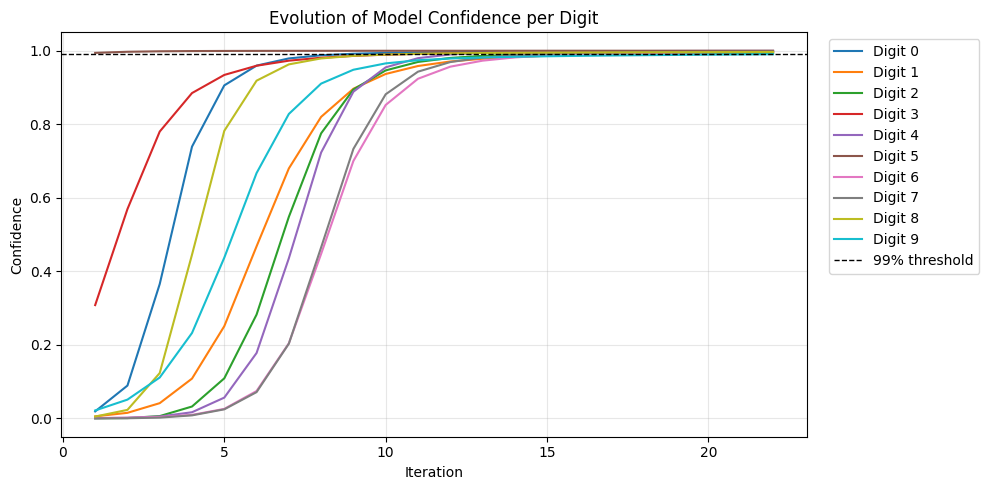

In [ ]:
conf_array = torch.stack(conf_history).cpu().numpy()  # shape [228, batch]
iters       = np.arange(1, conf_array.shape[0] + 1)

plt.figure(figsize=(10, 5))
for d in range(batch_size):
    plt.plot(iters, conf_array[:, d], label=f'Digit {d}')
plt.axhline(threshold, color='black', linestyle='--', linewidth=1,
            label=f'{int(threshold*100)}% threshold')
plt.xlabel('Iteration')
plt.ylabel('Confidence')
plt.title('Evolution of Model Confidence per Digit')
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

We sample snapshots (including the very first and very last) evenly across all iterations. Above each row of 10 images we show the current iteration number, the digit predicted, and the confidence level.


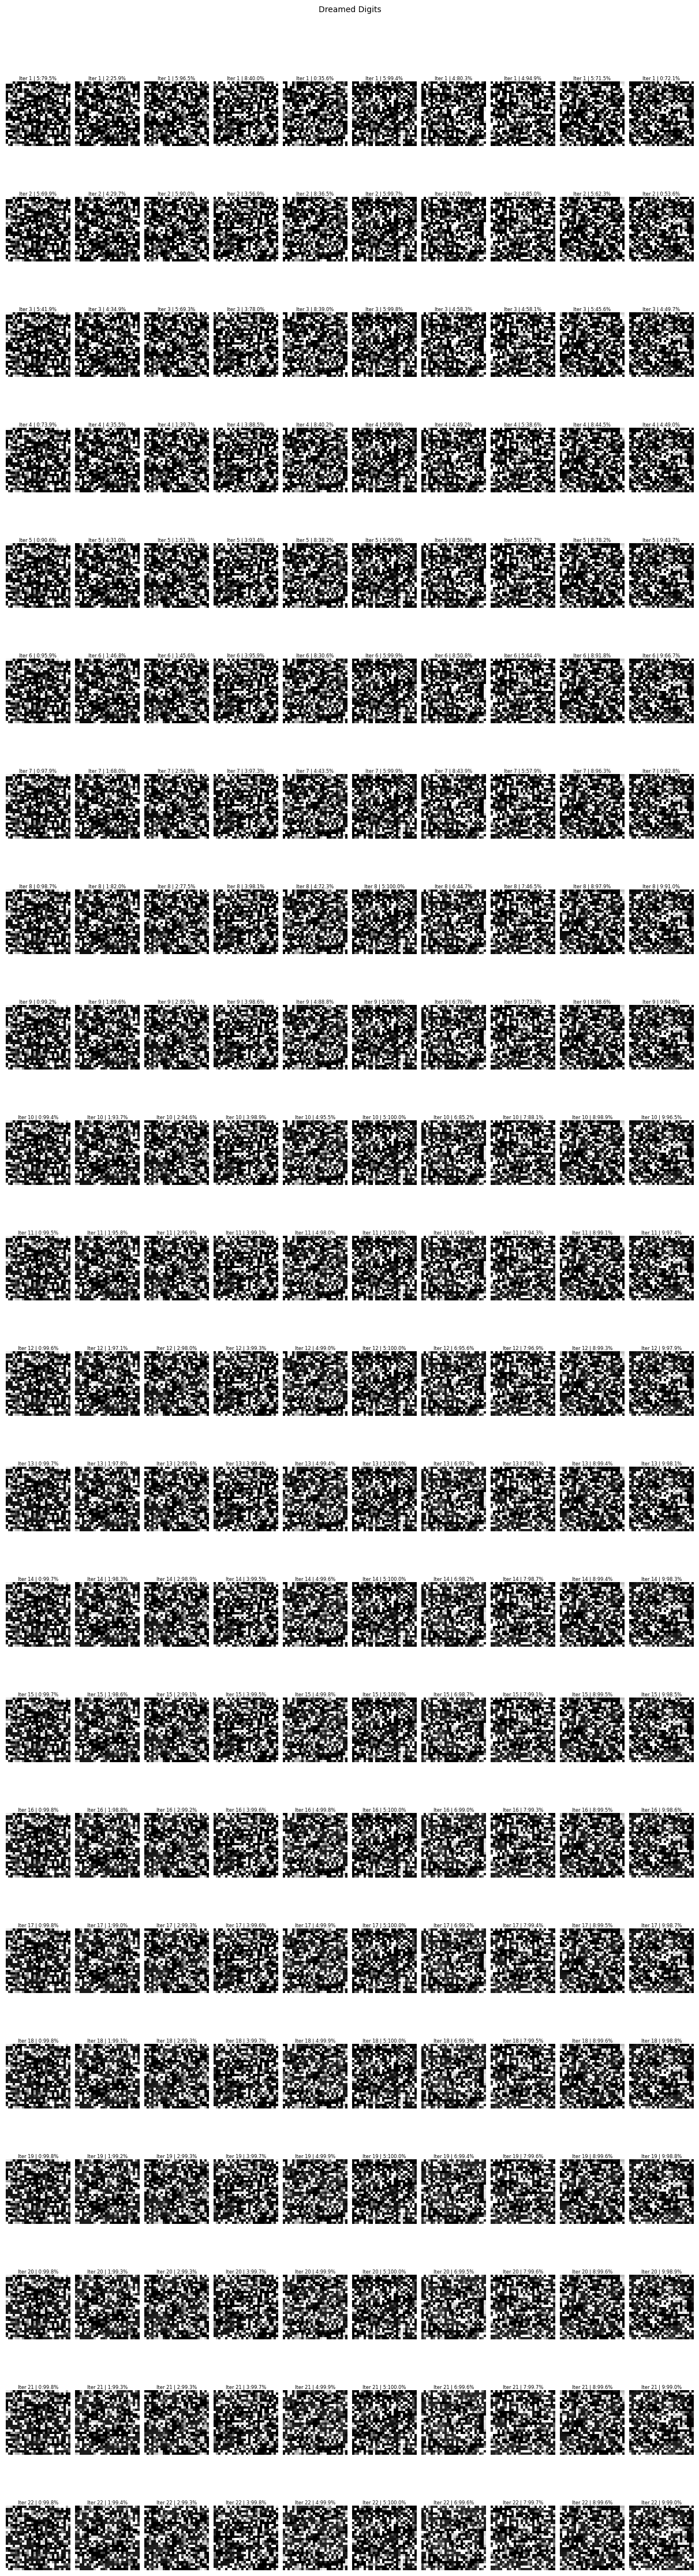

In [ ]:
# 1) Recomputing display_snaps, display_iters, display_preds, display_confs if needed
num_display   = min(25, len(snapshots))
total_steps   = len(snapshots)
idxs          = np.linspace(0, total_steps - 1, num_display, dtype=int)
display_snaps = [snapshots[i] for i in idxs]
display_iters = [i + 1 for i in idxs]

model.eval()
display_preds = []
display_confs = []
with torch.no_grad():
    for snap in display_snaps:
        logits = model(snap.to(device))
        probs  = F.softmax(logits, dim=1)
        confs, preds = probs.max(dim=1)
        display_confs.append(confs.cpu().numpy())
        display_preds.append(preds.cpu().numpy())

# 2) Plotting grid with titles above each image
fig, axes = plt.subplots(
    num_display, batch_size,
    figsize=(12, 2 * num_display),
    constrained_layout=True
)

for row, (snap, it) in enumerate(zip(display_snaps, display_iters)):
    for col in range(batch_size):
        ax = axes[row, col]
        ax.imshow(snap[col].squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
        pred = display_preds[row][col]
        conf = display_confs[row][col]
        ax.set_title(f"Iter {it} | {pred}:{conf*100:.1f}%", fontsize=6, pad=2)

plt.suptitle('Dreamed Digits', y=1.02, fontsize=10)
plt.show()

## Discussion - Comparing Unregularized CNN “Dream” Images to MLP Results  
In the experiments without any L₂ penalty, both networks produce highly confident yet visually noisy outputs. Below we discuss how these CNN-generated images compare in terms of readability, resemblance to genuine MNIST digits, and the architectural reasons behind their behavior — keeping in mind that the CNN reached over 99 % confidence in just 22 iterations, far faster than the MLP.

### 1. Readability  
When optimized without constraint, the images emerging from the CNN are no more legible than those from the MLP. Each image appears as a dense field of high-frequency artifacts rather than a coherent stroke. Although it might be possible to glimpse a fragment of a loop or a bar, the overall effect is speckled noise. The human eye cannot reliably distinguish one digit from another despite the model’s certainty.

### 2. Resemblance to Real Digits  
Unregularized outputs bear virtually no resemblance to authentic handwritten samples. Despite convolutional filters being trained on smooth curves and edges, the absence of a penalty term allows the optimizer to exploit weak spots in feature detectors, producing repeating local patterns that trigger a high class score. These patterns lack the continuity and global shape of MNIST digits, making them very "noisy", like the MLP outputs.

### 3. Underlying Architectural Causes  
The CNN’s weight-sharing and local receptive fields cause it to latch onto a small set of discriminative patches and tile them across the image, creating speckled textures. Pooling layers further encourage compact activations that can be maximized quickly. Because the CNN has far fewer free parameters in its final layers and a highly distributed feature hierarchy, it discovers these adversarial patterns in just 22 steps — whereas the MLP must tune many more weights and therefore converges more slowly. In both cases, without an L₂ penalty, the networks prefer trivial pixel hacks over genuine digit shapes.

---
# Task 1.2
**Repeat the previous task with an additional L2 penalty on noise within the images**

We first repeat Task 1’s optimization with an additional $L_2$ penalty on the input pixels.  The loss for a batch of inputs $x\in\mathbb{R}^{B\times1\times28\times28}$ and corresponding target labels is

$$
\mathcal{L}(x)
= \underbrace{\mathrm{CE}\bigl(\mathrm{softmax}(\mathrm{model}(x)),\,\mathrm{targets}\bigr)}_{\text{cross-entropy}}
+ \lambda_{12}\,\underbrace{\frac{1}{B}\sum_{b=1}^B \bigl\lVert x_b\bigr\rVert_2^2}_{\text{mean }L_2\text{ penalty}}
$$

where $\lambda_{12}$ controls how strongly we discourage large pixel values.  We sweep

$$
\lambda_{12} \in \{0.001,\;0.01,\;0.1,\;1,\;10\},
$$

re-initializing the noise and running a fixed number of Adam steps for each value.


We reseed here to guarantee the same noise every run, then create 10 images of shape 1×28×28.

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

batch_size = 10
dreamed    = torch.randn(batch_size, 1, 28, 28,
                         device=device, requires_grad=True)
targets    = torch.arange(batch_size, device=device)  # 0…9

We minimize  
$$
\mathcal{L} = \mathrm{CE}\bigl(\mathrm{softmax}(\mathrm{model}(x)),\,\mathrm{targets}\bigr)
              + \lambda_{12}\,\frac{1}{B}\sum_{b=1}^B \lVert x_b\rVert_2^2
$$  
via Adam on the inputs, clamping $x\in[0,1]$ each step, and stopping when all confidences ≥ 99 % or after 1000 iterations, similarly to the first task, but with the additional penalty.


In [ ]:
# 1) Hyperparameters & storage
batch_size    = 10
max_iters     = 1000
lr            = 0.01
lambda_values = [0.01, 0.1, 1, 10, 100]
threshold     = 0.99
targets       = torch.arange(batch_size, device=device)

final_images    = []
final_confs     = []
end_iters       = []
all_snapshots   = []
all_snap_iters  = []
conf_histories  = []

# 2) Sweeping over L2 penalties grid
for lambda_12 in lambda_values:
    # 2.1) Reseed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # per‐λ storage
    snapshots   = []
    snap_iters  = []
    history     = []

    # 2.2) Initializing trainable noise batch
    dreamed   = torch.randn(batch_size, 1, 28, 28,
                             device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed], lr=lr)

    # 2.3) Optimizing with L2 penalty, snapshot every 25 steps, early stopping
    for it in range(1, max_iters+1):
        optimizer.zero_grad()
        logits  = model(dreamed)
        ce_loss = F.cross_entropy(logits, targets)
        l2_pen  = dreamed.pow(2).mean()
        loss    = ce_loss + lambda_12 * l2_pen
        loss.backward()
        optimizer.step()
        dreamed.data.clamp_(0, 1)

        # record confidences
        with torch.no_grad():
            probs = F.softmax(model(dreamed), dim=1)
            confs = probs[range(batch_size), targets]

        history.append(confs.cpu().numpy())

        # snapshot every 25 iterations
        if it % 25 == 0:
            snapshots.append(dreamed.detach().cpu().clone())
            snap_iters.append(it)

        # early stopping
        if torch.all(confs >= threshold):
            print(f"λ = {lambda_12:.3f}: reached {threshold*100:.0f}% at iter {it}")
            end_iters.append(it)
            break
    else:
        print(f"λ = {lambda_12:.3f}: stopped after {max_iters} iterations; final confidences =",
              {i: f"{confs[i]*100:.1f}%" for i in range(batch_size)})
        end_iters.append(max_iters)

    # 2.4) Record final results
    final_images.append(dreamed.detach().cpu())
    final_confs.append(confs.cpu().numpy())
    all_snapshots.append(snapshots)
    all_snap_iters.append(snap_iters)
    conf_histories.append(np.stack(history))


λ = 0.010: reached 99% at iter 22
λ = 0.100: reached 99% at iter 22
λ = 1.000: reached 99% at iter 22
λ = 10.000: reached 99% at iter 22
λ = 100.000: stopped after 1000 iterations; final confidences = {0: '98.8%', 1: '98.5%', 2: '98.6%', 3: '98.5%', 4: '98.9%', 5: '99.5%', 6: '98.9%', 7: '98.7%', 8: '98.7%', 9: '97.9%'}


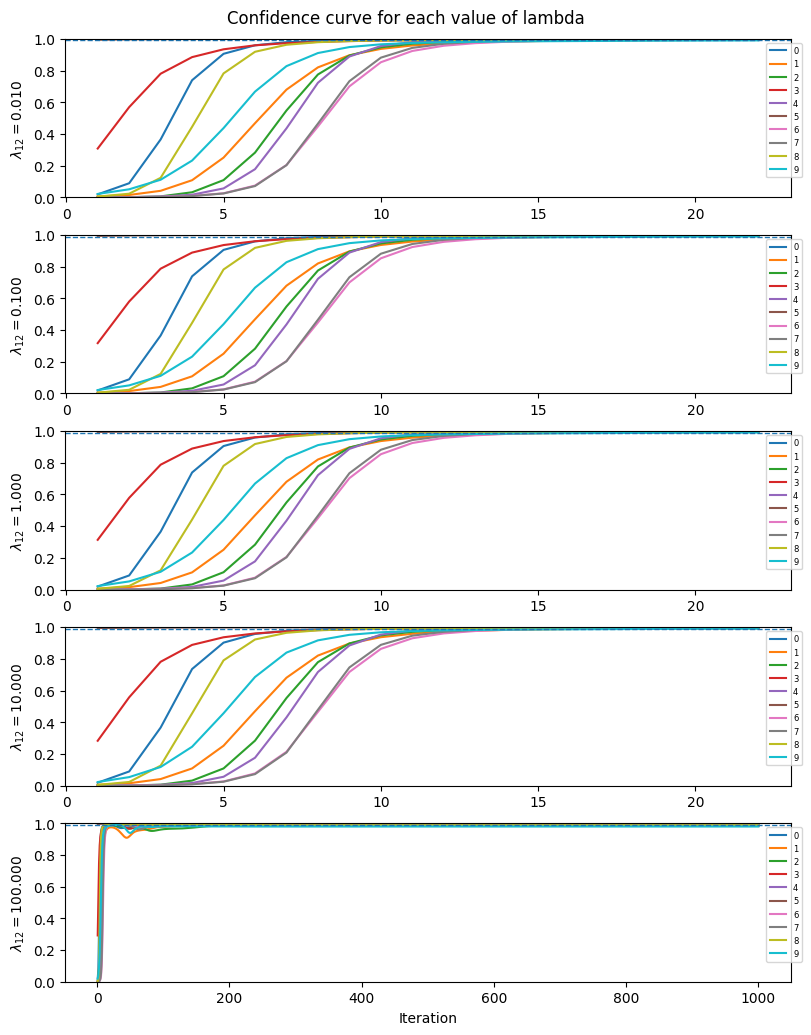

In [ ]:
fig, axes = plt.subplots(
    len(lambda_values), 1,
    figsize=(8, 2 * len(lambda_values)),
    sharex=False,
    constrained_layout=True
)

for ax, lam, history in zip(axes, lambda_values, conf_histories):
    n_iters = history.shape[0]
    iters = np.arange(1, n_iters + 1)
    for digit in range(batch_size):
        ax.plot(iters, history[:, digit], label=str(digit))
    ax.axhline(threshold, linestyle='--', linewidth=1)
    ax.set_ylabel(f"$\\lambda_{{12}}={lam:.3f}$")
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.02, 1), fontsize=6, ncol=1)

axes[-1].set_xlabel("Iteration")
plt.suptitle("Confidence curve for each value of lambda", y=1.02)
plt.show()

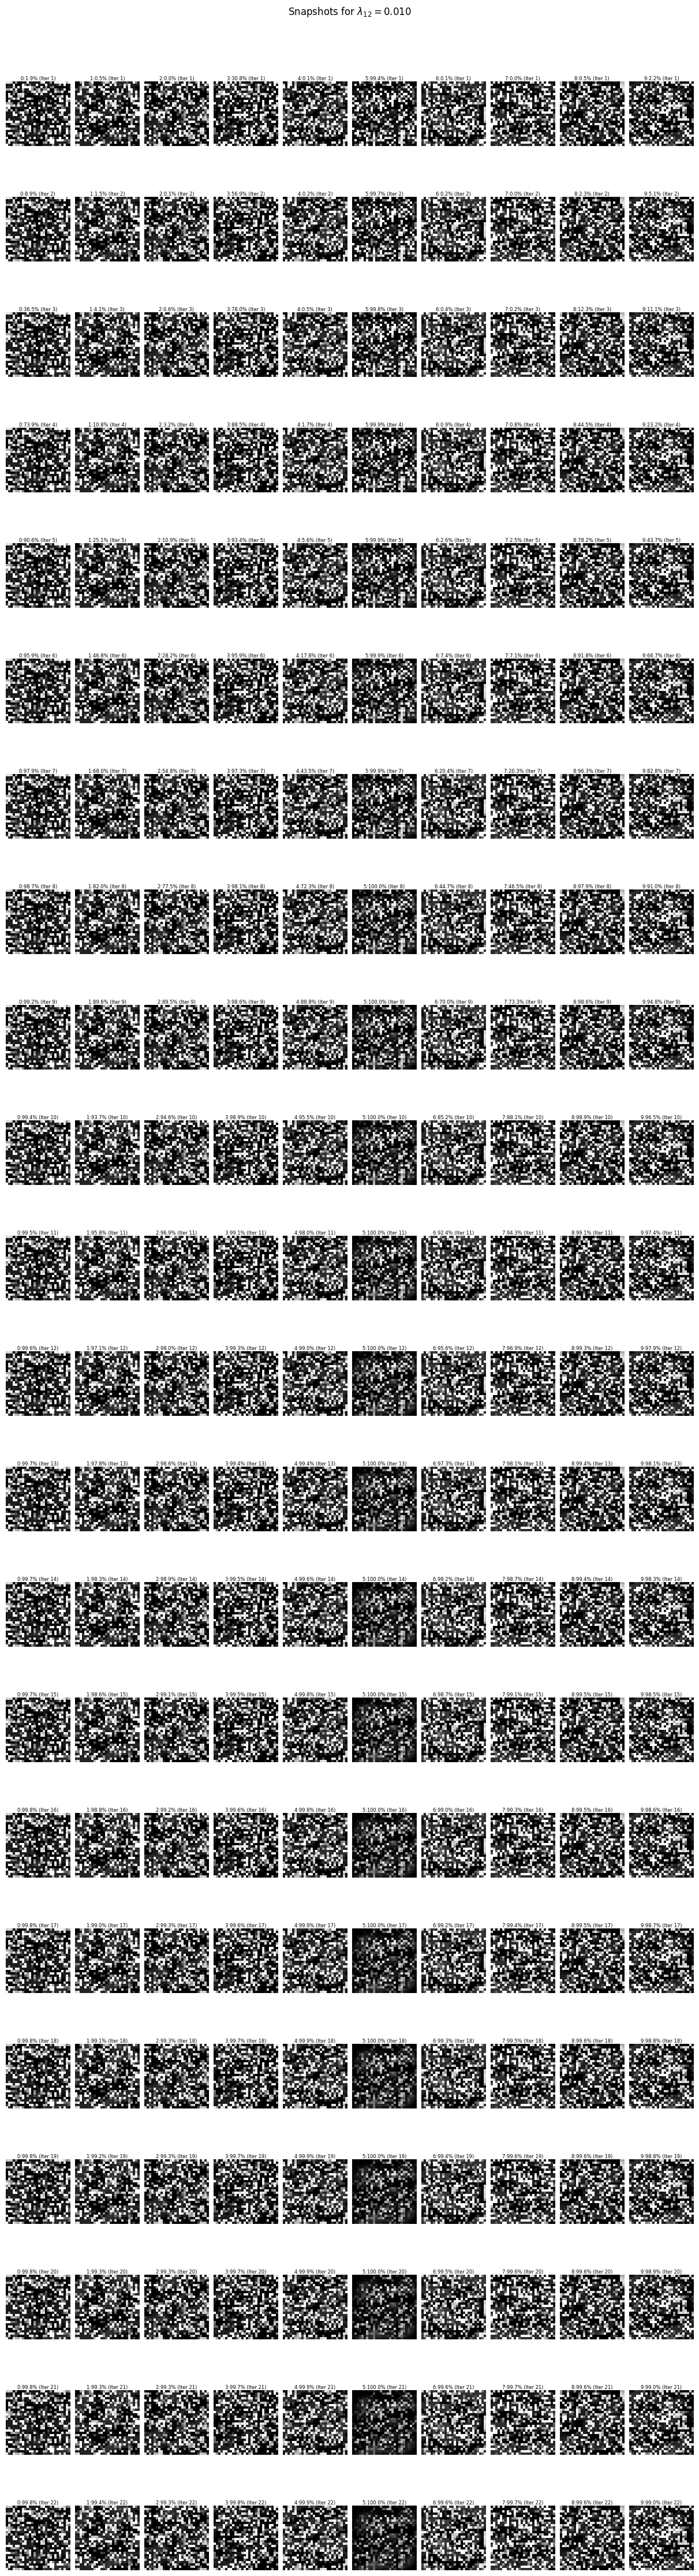

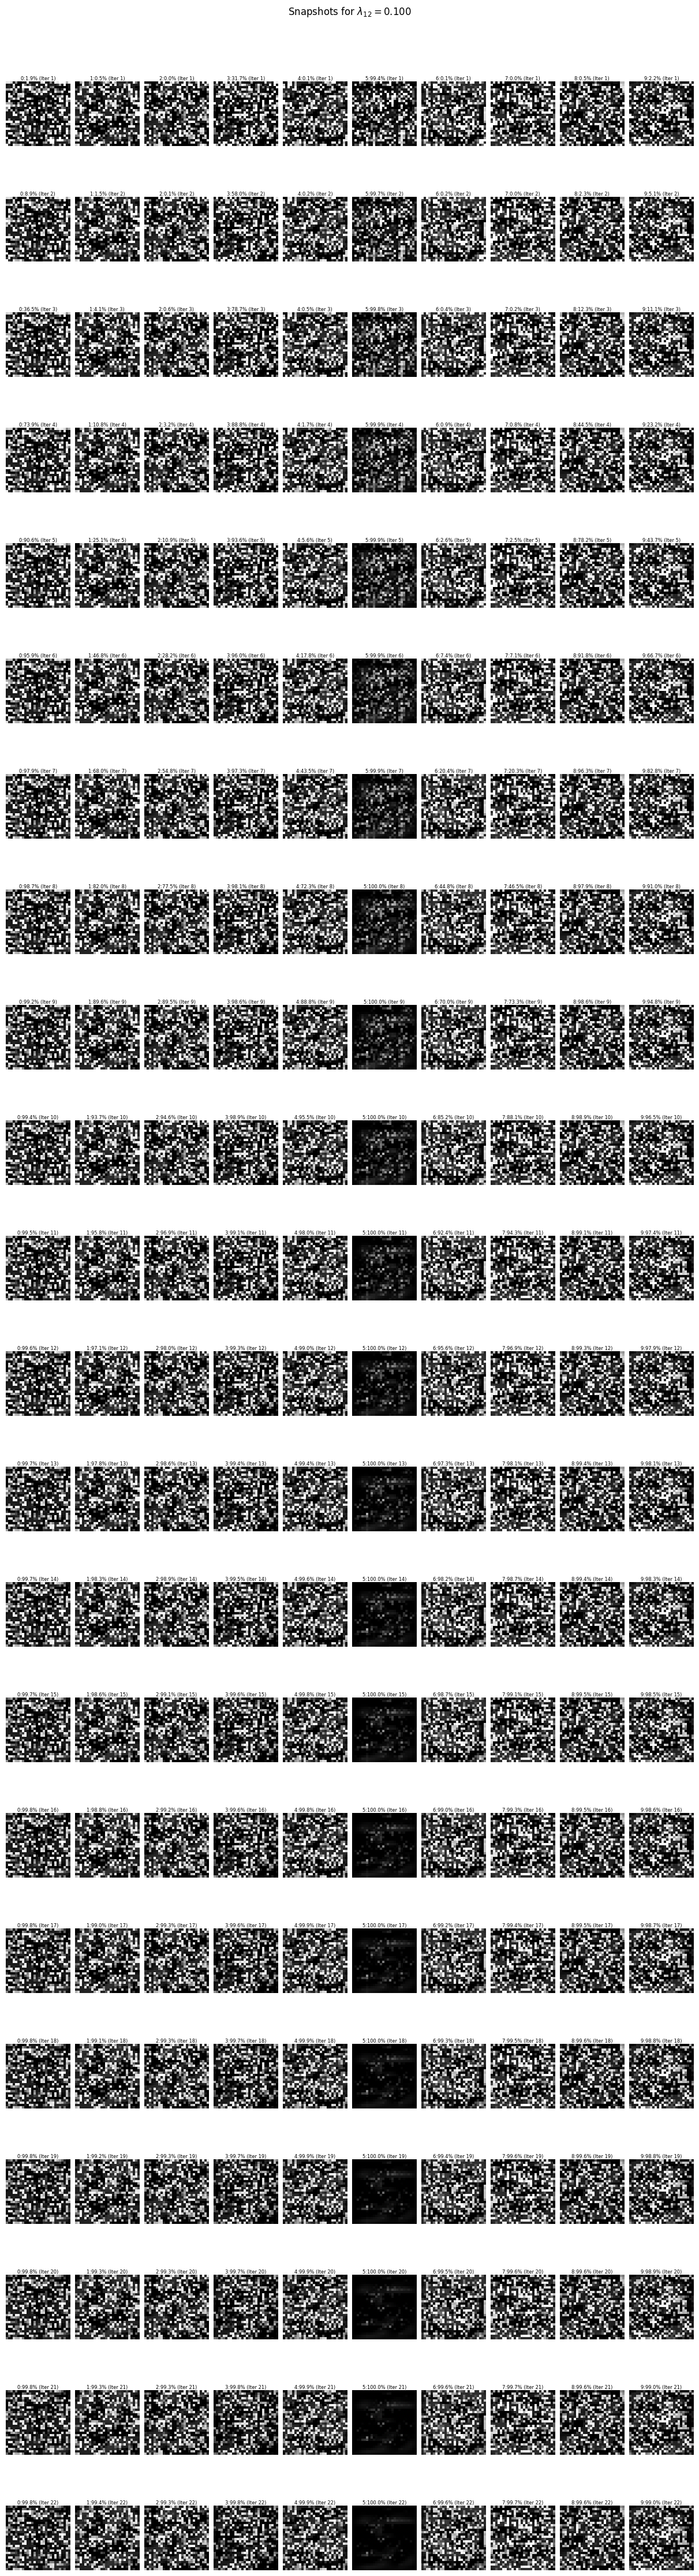

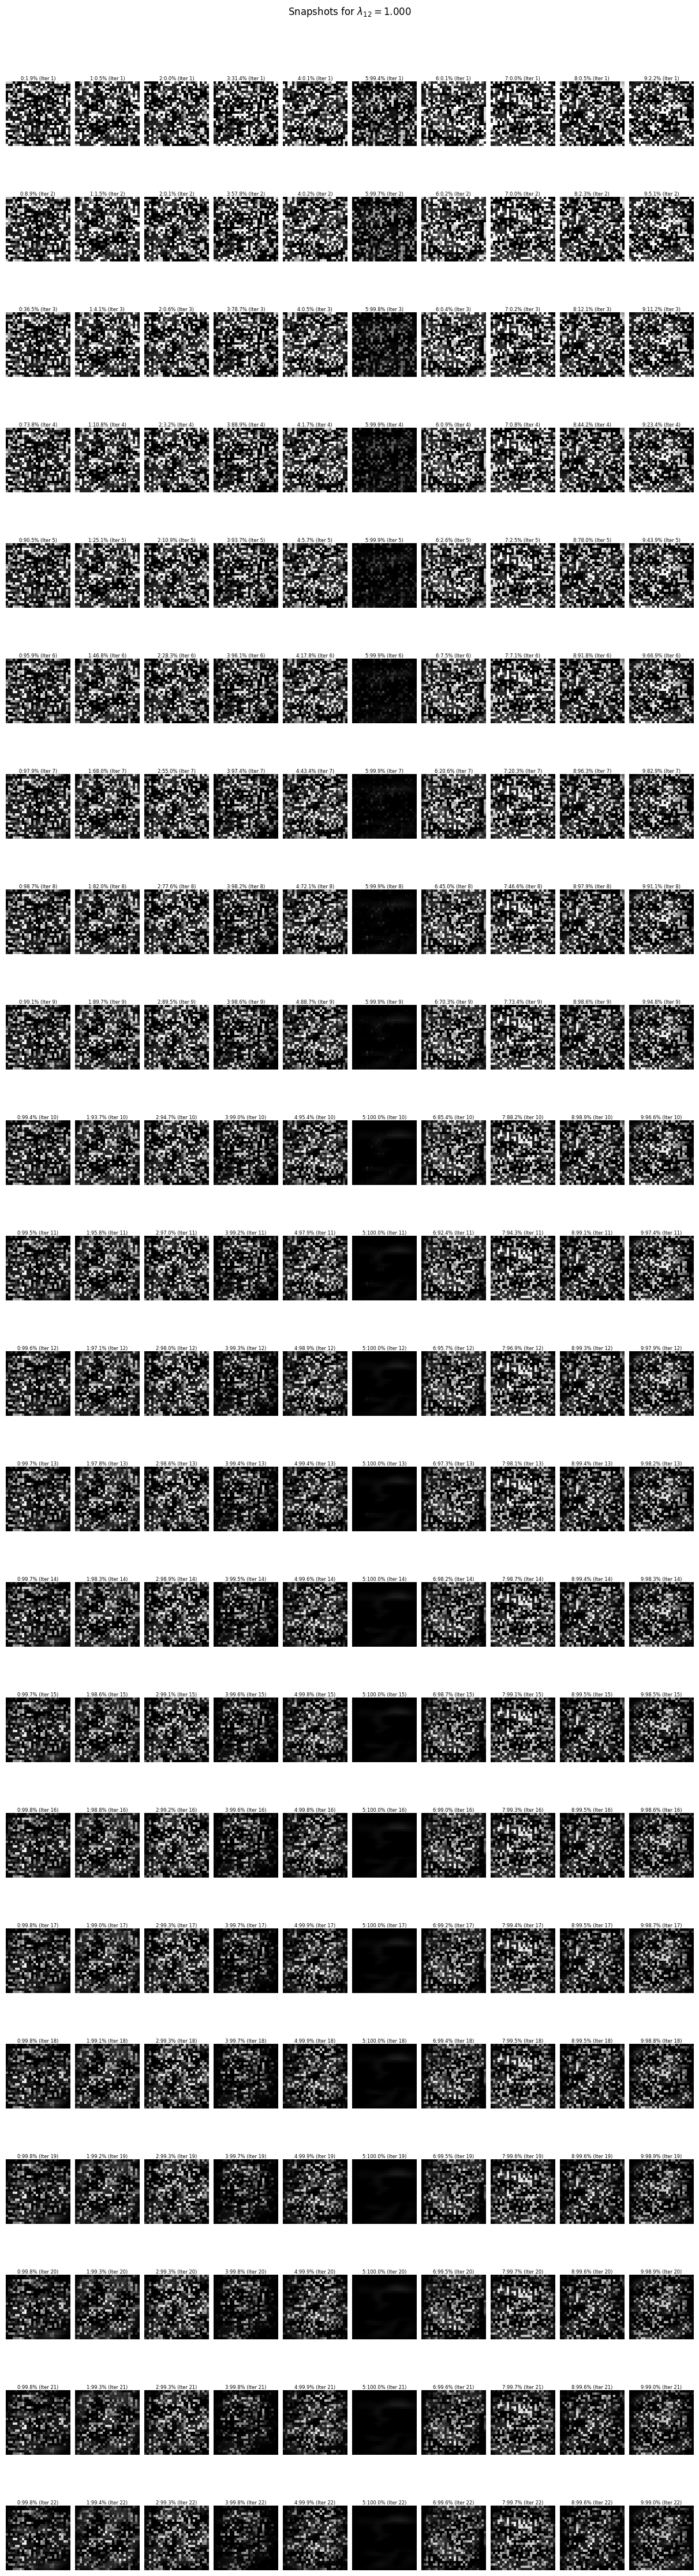

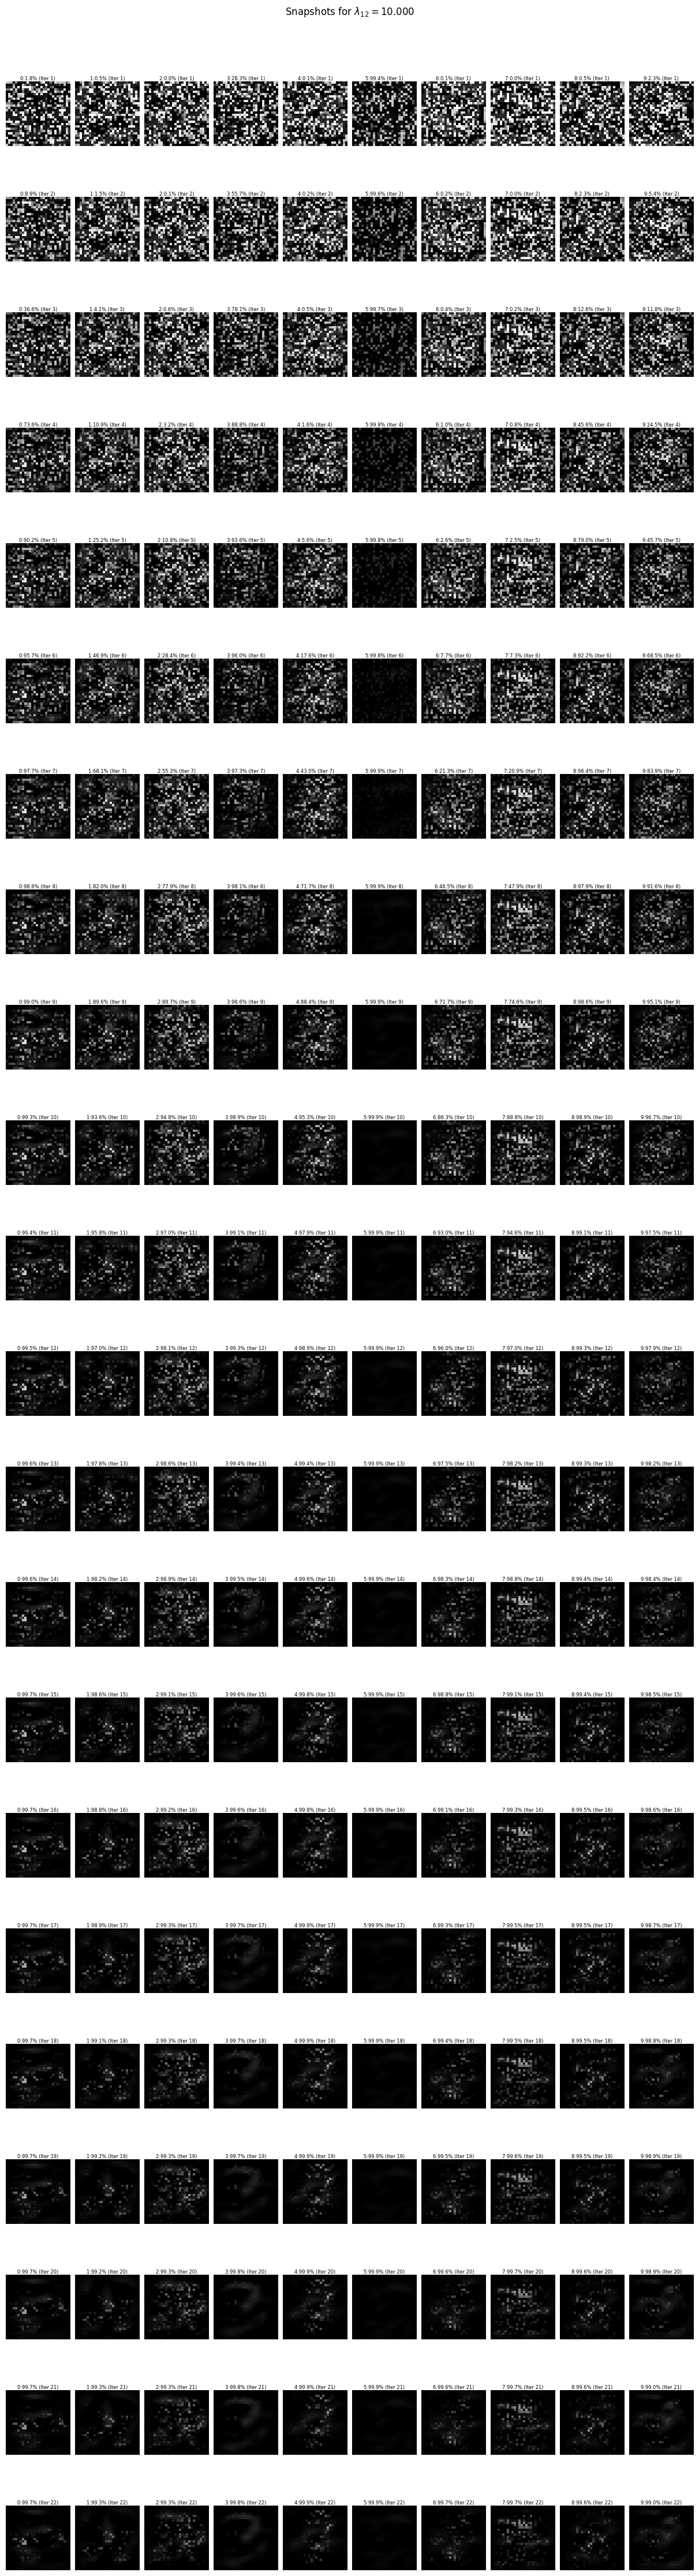

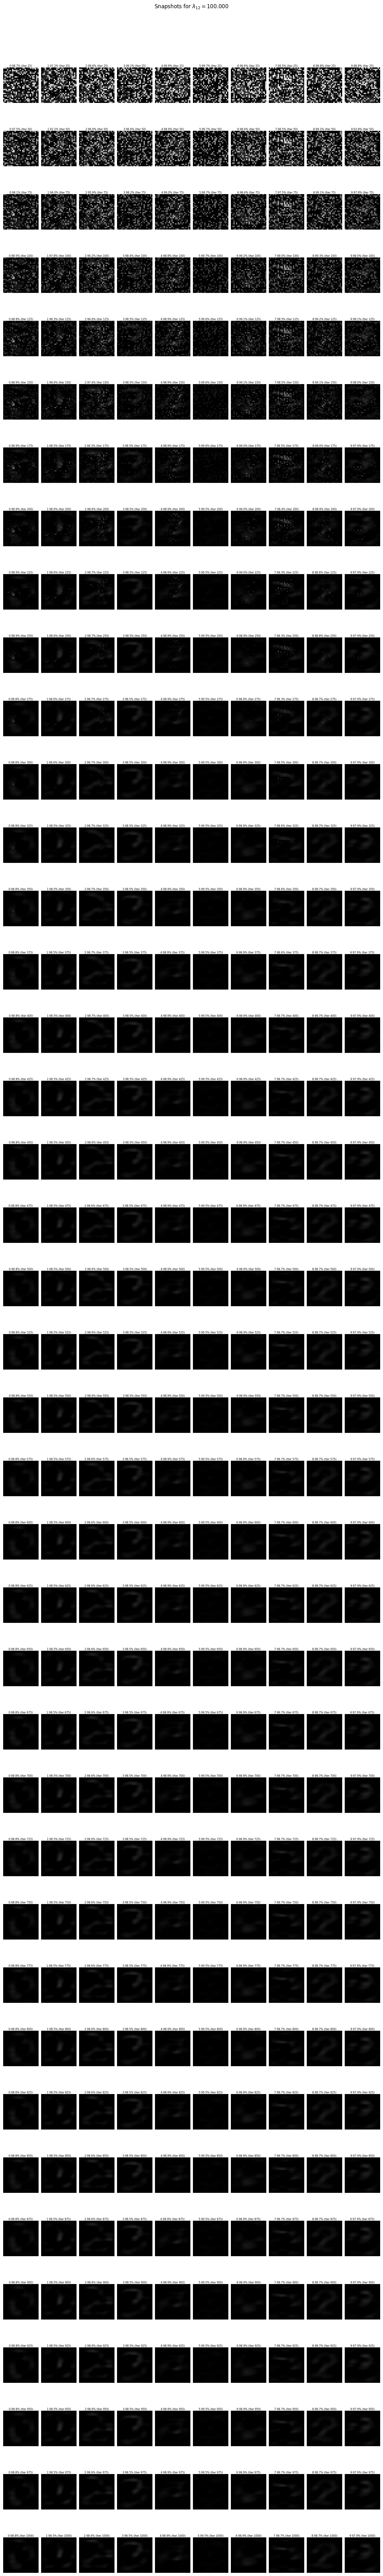

In [ ]:
for idx, lam in enumerate(lambda_values):
    snaps = all_snapshots[idx]
    n_run = end_iters[idx]
    history = conf_histories[idx]  # shape [n_run, batch_size]

    # build snapshot indices based on actual run length
    if n_run <= 25:
        its = list(range(1, n_run + 1))
    else:
        its = list(range(25, n_run + 1, 25))

    # fallback to final image if no snapshots were recorded
    if len(snaps) == 0:
        snaps = [final_images[idx]]
        its   = [n_run]

    num_rows = len(its)
    fig, axes = plt.subplots(
        num_rows,
        batch_size,
        figsize=(12, 2 * num_rows),
        constrained_layout=True
    )

    for r, it in enumerate(its):
        img_batch = snaps[r].to(device)  # [batch_size, 1, 28, 28]
        # pull the exact target-class confidences from your recorded history
        row_confs = history[it - 1]      # zero-based indexing into history
        for c in range(batch_size):
            ax = axes[r, c] if num_rows > 1 else axes[c]
            ax.imshow(img_batch[c].squeeze(), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
            label = targets[c].item()
            ax.set_title(f"{label}:{row_confs[c]*100:.1f}% (Iter {it})",
                         fontsize=6, pad=2)

        if num_rows > 1:
            axes[r, 0].set_ylabel(f"Iter {it}", rotation=0,
                                   labelpad=20, va='center')
        else:
            axes[0].set_ylabel(f"Iter {it}", rotation=0,
                               labelpad=20, va='center')

    fig.suptitle(fr"Snapshots for $\lambda_{{12}}={lam:.3f}$", y=1.02)
    plt.show()

## Discussion - L₂ - Penalized “Dream” Images

When we add an L₂ penalty on the input, the optimizer can no longer exploit high-frequency noise and starts building smoother strokes in some cases. In the MLP, $λ=10$ never reached 99 % confidence but after 1000 iterations its images showed clearer curves. In contrast, the CNN with $λ = 10$ hit 99 % in just 22 iterations, while $λ=100$ (which was absent in the MLP-based analysis, but we added it to showcase a similar effect to the one that occured there with $λ=10$) fell just below full confidence but produced more recognizable outputs .

### 1. Readability  
With $λ=10$ on the CNN, the network finds a minimal set of strokes in only 22 steps: by iteration 22, once can observe some smoother strokes and less noise as compared to smaller penalties. Pushing to $λ=100$ slows progress — confidence stalls just under 99 % — but by iteration 1000 the faint outlines of the digits emerge. In the MLP case, $λ=10$ never quite hit 100 % but its 1000-step output also showed improved stroke continuity compared to smaller penalties and the unpenalized noise.


### 2. Resemblance to Real MNIST Digits  
The CNN’s $λ=10$ images start looking like outlines of the real digits, but with significant noise still present. At $λ=100$, the outlines become more recoginizable. The MLP under $λ=10$ also cleans up its shapes after 1000 iterations, but its global coordination of strokes is still less faithful than the CNN’s due to its lack of spatial weight sharing.

### 3. Architectural Explanation  
The L₂ term forces the optimizer to trade confidence for minimal pixel energy. In the CNN-based version, weight sharing and small convolutional kernels bias the model toward local stroke detectors; with large λ these detectors must act in sync to reach high confidence, starting to produce smoother shapes. This strong inductive bias lets the model with the $λ=10$ produce something that starts resembling digit shapes. When $λ=100$, the penalty dominates and slows convergence confidence-wise (never quite hitting 99 %), but continued iterations stitch together the same filters into recognizable outlines. In the MLP scenario, due to it lacking convolutional structure, it must tune every input weight independently, so even with $λ=10$ it only gradually assembles rough digit forms over hundreds of iterations.

# Task 2: Crafting Adversarial Examples

In this task we will take real MNIST digits, learn small additive perturbations $δ$ that cause LeNet-5 to misclassify them, and analyze how the strength of an L₂ penalty on $δ$ affects attack success and visibility of the noise.

We will:
- Select one representative MNIST digit 0–9.
- For each, craft nine targeted attacks (one per *wrong* label).
- Vary $\lambda_2 \in \{0,0.01,0.1,1,10\}$, record success & visibility.



In [ ]:
#Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
## 1) Picking one test image per class (0–9)

test_ds  = MNIST('.', train=False, download=True, transform=transforms.ToTensor())
one_per = {}
for img, lbl in test_ds:
    if lbl not in one_per:
        one_per[lbl] = img
    if len(one_per) == 10:
        break

orig_imgs  = [one_per[i].unsqueeze(0).to(device) for i in range(10)]
orig_lbls  = list(range(10))
batch_size = len(orig_imgs)  # =10

We sweep $\lambda \in \{0, 0.01, 0.1, 1, 10\}$, clamp $\delta\in[-0.3,+0.3]$, run Adam for 200 steps, and save:
- Success: did target-wrong win?
- History of target-conf vs iter
- Final ‖δ‖₂ and final perturbed images

In [111]:
lambda_values = [0.0, 0.01, 0.1, 1.0, 10.0]
lr            = 0.01
max_iters     = 200
eps           = 0.3

results     = []
conf_curves = []
grid_all    = []
total_attacks = batch_size * 9


For each true image and each wrong target we minimize

$$
\text{loss} = \mathrm{cross\_entropy}\bigl(\text{model}(x + \delta),\,y_{\text{wrong}}\bigr)
+ \lambda\,\|\delta\|_2^2
$$

then record success, noise norm, and confidence history.

In [112]:
# %% [code]
for lam in lambda_values:
    success   = 0
    norms     = []
    conf_hist = torch.zeros(max_iters, total_attacks, device=device)
    grid      = []
    atk_idx   = 0

    for x_orig, y_true in zip(orig_imgs, orig_lbls):
        for wrong_lbl in range(10):
            if wrong_lbl == y_true:
                continue

            # init δ for this single (x_orig → wrong_lbl) attack
            delta = torch.zeros_like(x_orig, requires_grad=True, device=device)
            opt   = torch.optim.Adam([delta], lr=lr)

            # optimize δ for max_iters
            for it in range(max_iters):
                opt.zero_grad()
                logits = model(x_orig + delta)
                ce     = F.cross_entropy(logits, torch.tensor([wrong_lbl], device=device))
                l2     = delta.pow(2).mean()
                (ce + lam * l2).backward()
                opt.step()
                delta.data.clamp_(-eps, eps)

                with torch.no_grad():
                    probs = F.softmax(model(x_orig + delta), dim=1)  # [1,10]
                    # record confidence in the targeted wrong class
                    conf_hist[it, atk_idx] = probs[0, wrong_lbl]

            # final evaluation
            with torch.no_grad():
                probs = F.softmax(model(x_orig + delta), dim=1)[0]  # [10]
                pred  = probs.argmax().item()
                conf  = probs[wrong_lbl].item()

            success += int(pred == wrong_lbl)
            norms.append(delta.norm().item())
            grid.append((x_orig.cpu(),
                         delta.detach().cpu() + x_orig.cpu(),
                         y_true, wrong_lbl, conf))
            atk_idx += 1

    acc = success / total_attacks
    results.append((lam, acc, float(torch.tensor(norms).mean())))
    # average confidence curve over all attacks
    conf_curves.append(conf_hist.mean(dim=1).cpu().numpy())
    grid_all.append(grid)

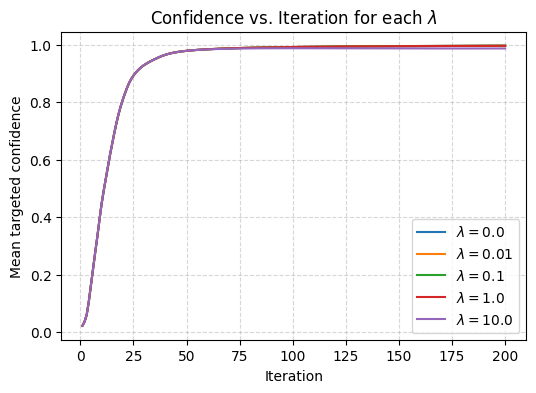

In [119]:
plt.figure(figsize=(6,4))
for lam, curve in zip(lambda_values, conf_curves):
    plt.plot(np.arange(1, max_iters+1), curve, label=f"$\\lambda={lam}$")
plt.xlabel("Iteration")
plt.ylabel("Mean targeted confidence")
plt.title("Confidence vs. Iteration for each $\\lambda$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The code below iterates over each penalty weight $\lambda$ and, for each true digit (0–9), selects the single adversarial perturbation that achieved the highest final confidence in its wrong target. The resulting figures have two columns—original and adversarial—for all ten classes, giving a comprehensive overview of the most effective attacks at each regularization strength.

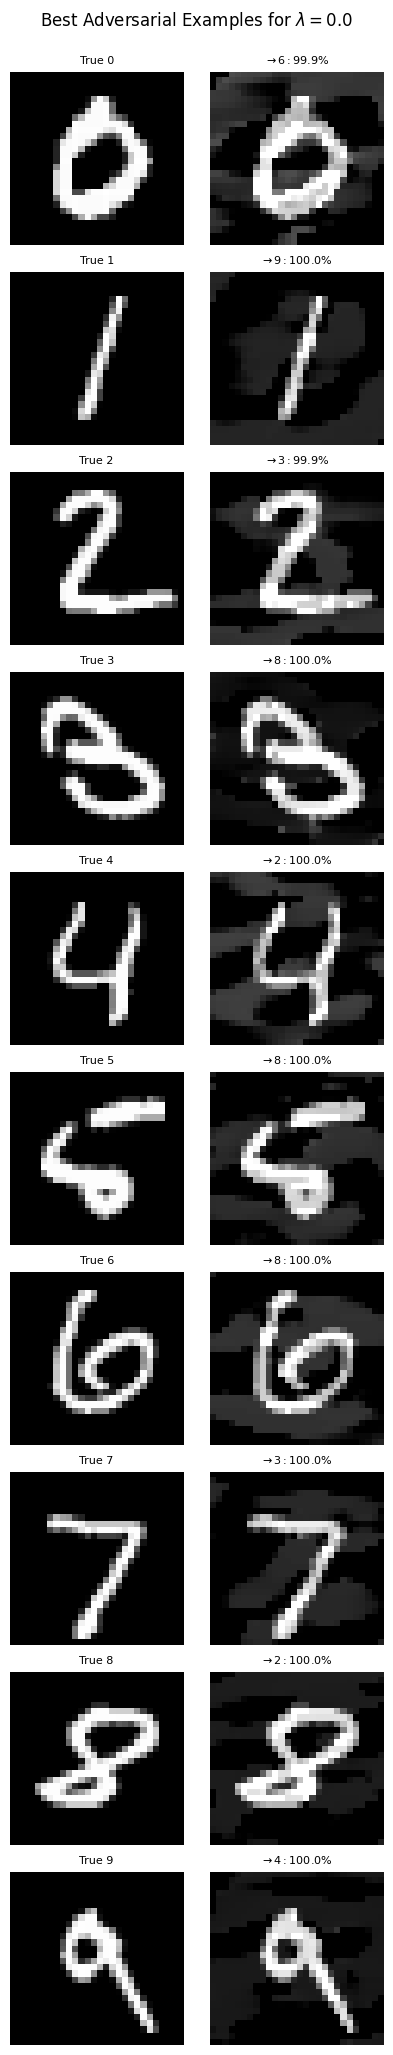

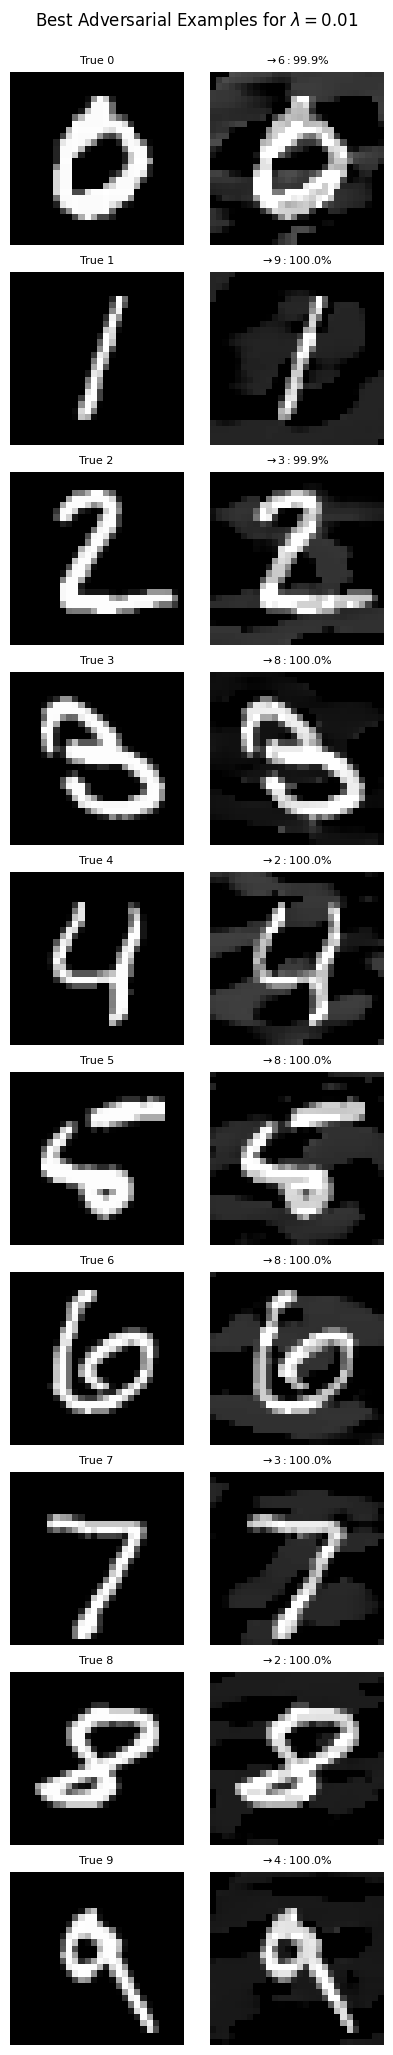

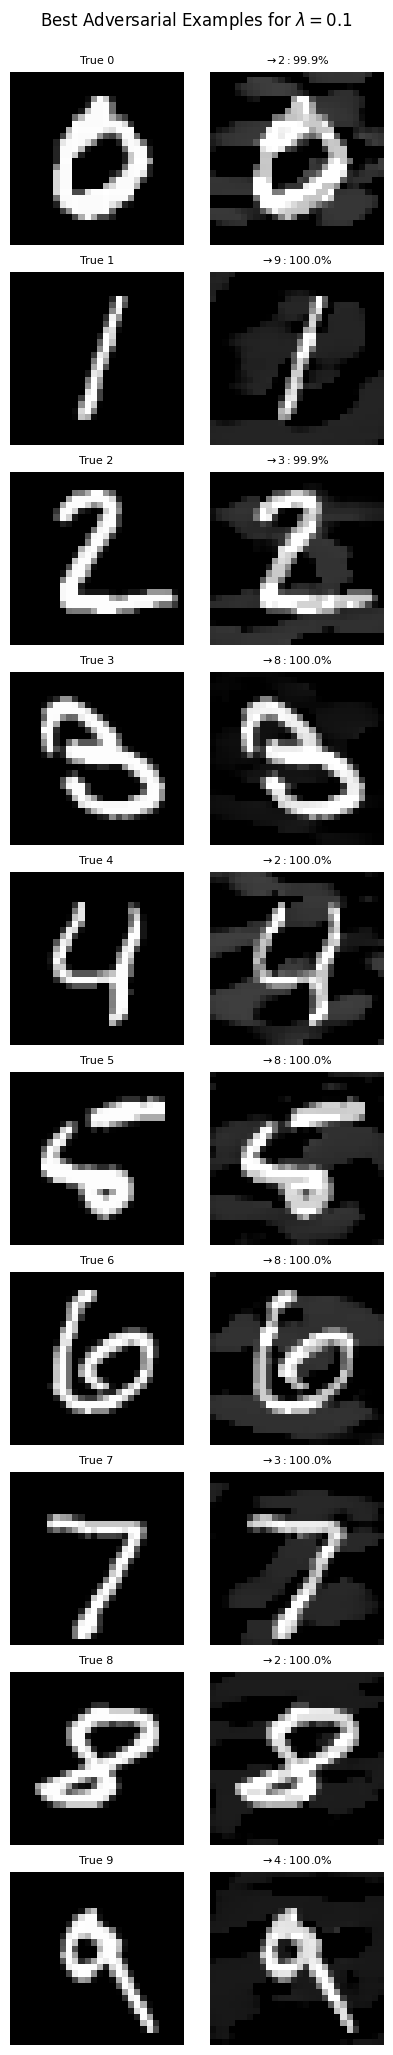

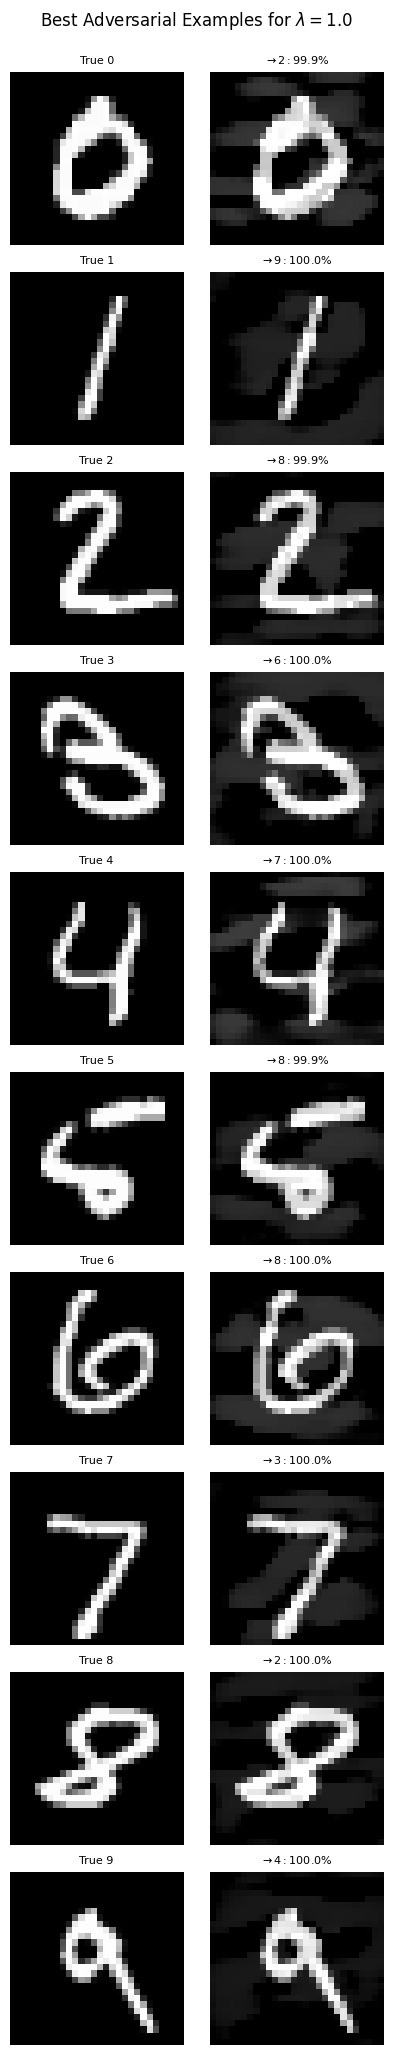

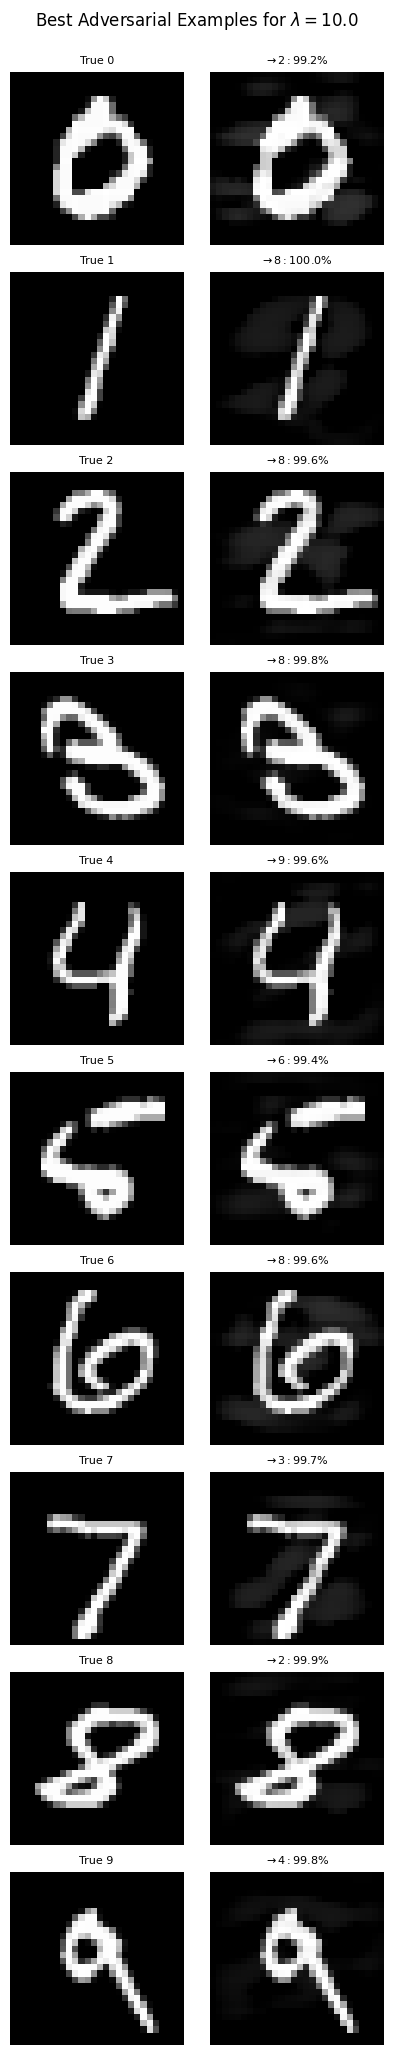

In [120]:
for idx, lam in enumerate(lambda_values):
    grid = grid_all[idx]   # list of (orig, adv, true_lbl, wrong_lbl, conf)
    best_per_class = []
    for cls in range(10):
        # filter to attacks whose original label == cls
        cls_attacks = [g for g in grid if g[2] == cls]
        # pick the one with highest confidence
        best = max(cls_attacks, key=lambda x: x[4])
        best_per_class.append(best)

    fig, axes = plt.subplots(10, 2, figsize=(4, 20), constrained_layout=True)
    for r, (orig, adv, t_lbl, w_lbl, conf) in enumerate(best_per_class):
        axes[r,0].imshow(orig.squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[r,0].axis('off')
        axes[r,0].set_title(f"True {t_lbl}", fontsize=8)

        axes[r,1].imshow(adv.squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[r,1].axis('off')
        axes[r,1].set_title(f"$\\to{w_lbl}:{conf*100:.1f}\\%$", fontsize=8)

    fig.suptitle(f"Best Adversarial Examples for $\\lambda={lam}$", y=1.02)
    plt.show()